## Project- Choose Your own Hypothesis: Crash Reporting-Drivers Data in Montgomery County
- This dataset provides information on motor vehicle operators (drivers) involved in traffic collisions occurring on county and local roadways. The dataset reports details of all traffic collisions occurring on county and local roadways within Montgomery County, as collected via the Automated Crash Reporting System (ACRS) of the Maryland State Police, and reported by the Montgomery County Police, Gaithersburg Police, Rockville Police, or the Maryland-National Capital Park Police. This dataset shows each collision data recorded and the drivers involved.

- You can get get the dataset using this link: https://catalog.data.gov/dataset/crash-reporting-drivers-data


## Setup



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Your Dataset


In [2]:
crash_data = pd.read_csv('Crash_Reporting_Drivers_Data.csv')

/var/folders/7z/yhc6hjjd60qbcwtnhw68lgr00000gn/T/ipykernel_3904/3792754575.py:1: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  crash_data = pd.read_csv('Crash_Reporting_Drivers_Data.csv')


## Initial Exploration

In [3]:
crash_data.head()
crash_data.info()
crash_data.describe()
crash_data.isnull().sum()
crash_data.shape

#crash_data = crash_data[['CRASH_ID', 'DRIVER_ID', 'DISTRACTED', 'AT_FAULT']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206309 entries, 0 to 206308
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Report Number                  206309 non-null  object 
 1   Local Case Number              206309 non-null  object 
 2   Agency Name                    206309 non-null  object 
 3   ACRS Report Type               206309 non-null  object 
 4   Crash Date/Time                206309 non-null  object 
 5   Route Type                     186120 non-null  object 
 6   Road Name                      182865 non-null  object 
 7   Cross-Street Name              168701 non-null  object 
 8   Off-Road Description           19149 non-null   object 
 9   Municipality                   19126 non-null   object 
 10  Related Non-Motorist           6734 non-null    object 
 11  Collision Type                 205724 non-null  object 
 12  Weather                       

(206309, 39)

## 1. Cleaning

In [4]:
# Clean 'Driver Distracted By': Normalize text and handle NAs
crash_data['Driver Distracted By'] = crash_data['Driver Distracted By'].astype(str).str.strip().str.upper()

# Clean 'Driver At Fault': Normalize text
crash_data['Driver At Fault'] = crash_data['Driver At Fault'].astype(str).str.strip().str.upper()

In [5]:
# Define lists for categorization
not_distracted_vals = ['NOT DISTRACTED']
unknown_vals = ['UNKNOWN', 'NO DRIVER PRESENT', 'NAN', 'nan']

# Function to categorize distraction status
def classify_distraction(val):
    if val in not_distracted_vals:
        return 'Not Distracted'
    elif val in unknown_vals:
        return 'Unknown'
    else:
        return 'Distracted'

# Apply the classification
crash_data['Distraction_Status'] = crash_data['Driver Distracted By'].apply(classify_distraction)

# Filter data: Remove 'Unknown' distraction and ensure Fault is Yes/No
clean_df = crash_data[
    (crash_data['Distraction_Status'] != 'Unknown') & 
    (crash_data['Driver At Fault'].isin(['YES', 'NO']))
].copy()

# Create numeric binary columns for analysis (1=Yes, 0=No)
clean_df['is_at_fault'] = (clean_df['Driver At Fault'] == 'YES').astype(int)

## 2. Descriptive Statistics (Observed Data)

In [6]:
# Calculate the proportion of "At Fault" drivers in both groups
group_stats = clean_df.groupby('Distraction_Status')['is_at_fault'].mean()
p_distracted = group_stats['Distracted']
p_not_distracted = group_stats['Not Distracted']
obs_diff = p_distracted - p_not_distracted

print(f"Observed Proportion (Distracted): {p_distracted:.2%}")
print(f"Observed Proportion (Not Distracted): {p_not_distracted:.2%}")
print(f"Observed Difference: {obs_diff:.4f}")

Observed Proportion (Distracted): 95.97%
Observed Proportion (Not Distracted): 30.39%
Observed Difference: 0.6558


## 3. Permutation Test (P-Value)

In [7]:
# We simulate a world where distraction has NO effect on fault by shuffling labels.

n_permutations = 5_000
perm_diffs = []

# Create a copy of the fault array to shuffle
fault_array = clean_df['is_at_fault'].values.copy()
n_distracted_count = (clean_df['Distraction_Status'] == 'Distracted').sum()

np.random.seed(42) # For reproducibility

for _ in range(n_permutations):
    np.random.shuffle(fault_array) # Shuffle the "At Fault" labels
    
    # Split into two fake groups based on the original sizes
    fake_distracted = fault_array[:n_distracted_count]
    fake_not_distracted = fault_array[n_distracted_count:]
    
    # Calculate difference for this simulation
    perm_diffs.append(np.mean(fake_distracted) - np.mean(fake_not_distracted))

# Calculate P-Value: How often was the random difference >= our observed difference?
p_value = np.mean(np.array(perm_diffs) >= obs_diff)
print(f"Permutation P-value: {p_value:.4f}")

Permutation P-value: 0.0000


## 4. Bootstrap (Uncertainty Estimation)

In [8]:
# We resample WITH replacement to estimate the Confidence Interval (CI).

n_bootstraps = 5_000
boot_diffs = []

# Separate the true groups
distracted_data = clean_df[clean_df['Distraction_Status'] == 'Distracted']['is_at_fault'].values
not_distracted_data = clean_df[clean_df['Distraction_Status'] == 'Not Distracted']['is_at_fault'].values

np.random.seed(42)

for _ in range(n_bootstraps):
    # Resample with replacement
    boot_dist = np.random.choice(distracted_data, size=len(distracted_data), replace=True)
    boot_not = np.random.choice(not_distracted_data, size=len(not_distracted_data), replace=True)
    
    # Calculate difference
    boot_diffs.append(np.mean(boot_dist) - np.mean(boot_not))

# Calculate 95% Confidence Interval
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)

print(f"95% Bootstrap CI: ({ci_lower:.4f}, {ci_upper:.4f})")

95% Bootstrap CI: (0.6525, 0.6591)


## 5. Visualizations

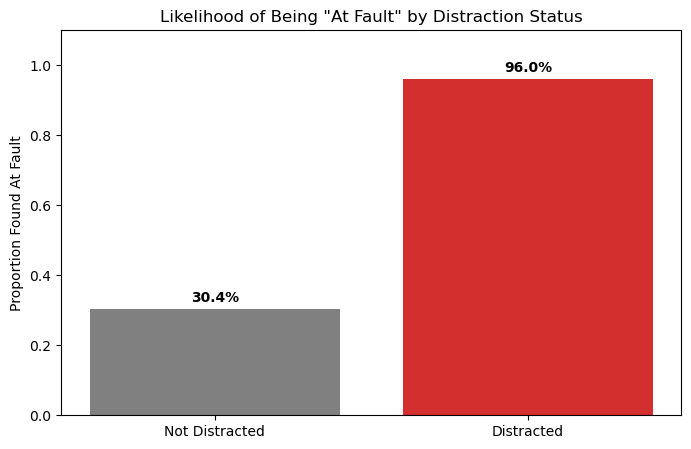

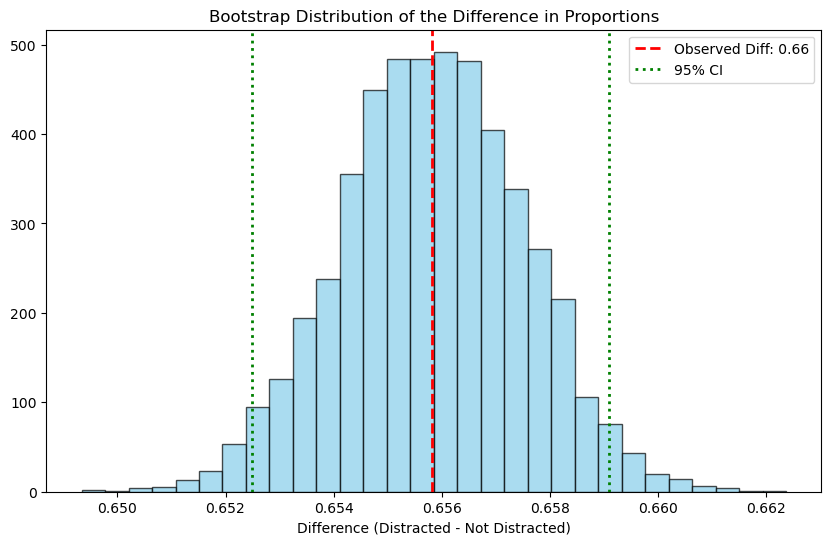

In [9]:
# Plot 1: Bar Chart of Proportions
plt.figure(figsize=(8, 5))
plt.bar(['Not Distracted', 'Distracted'], [p_not_distracted, p_distracted], color=['grey', '#D32F2F'])
plt.title('Likelihood of Being "At Fault" by Distraction Status')
plt.ylabel('Proportion Found At Fault')
plt.ylim(0, 1.1)
plt.text(0, p_not_distracted + 0.02, f"{p_not_distracted:.1%}", ha='center', fontweight='bold')
plt.text(1, p_distracted + 0.02, f"{p_distracted:.1%}", ha='center', fontweight='bold')
plt.savefig('proportion_plot.png') # Saves the image
plt.show()

# Plot 2: Bootstrap Distribution
plt.figure(figsize=(10, 6))
plt.hist(boot_diffs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(obs_diff, color='red', linestyle='--', linewidth=2, label=f'Observed Diff: {obs_diff:.2f}')
plt.axvline(ci_lower, color='green', linestyle=':', linewidth=2, label='95% CI')
plt.axvline(ci_upper, color='green', linestyle=':', linewidth=2)
plt.title('Bootstrap Distribution of the Difference in Proportions')
plt.xlabel('Difference (Distracted - Not Distracted)')
plt.legend()
plt.savefig('bootstrap_distribution.png') # Saves the image
plt.show()